# Predictability of Player Subscription Status - DSCI 100 Project: Section 5 Group 31
By Jessica Ho, Justin Pilson, Ansen Chieng

# Introduction
We will be investigating the behaviour of people who play games using the dataset `players.csv` which was collected by Frank Wood's research group at UBC Computer Science from a MineCraft server that records each individual player's information. This information is collected to gain knowledge on how to go about player recruitment and the resources required to handle the amount of players.

From the `players.csv` dataset we are investigating, "Can age and hours played predict if a player has subscribed to the newsletter?" To have success in the gaming industry, it is important to prioritize player engagement and retention. One way to maintain engagement is through newsletter subscription. However, not all players subscribe to the newsletter, allowing for identification of factors that affect player subscription. Understanding trends of player variables can help tailor marketing strategies such as personalized outreach, to target specific players based on their behaviour.

The `players.csv` dataset represents different information of all players recorded in the dataset; the variables include:
- experience: How experienced the player is in MineCraft (Rank: Beginning, Amateur, Regular, Pro, Veteran), Type: character
- subscribe: Whether or not the player as subscribed to the game related newsletter (True or False), Type: logical
- hashedEmail: The email of each player converted into a string of different characters, Type: character
- played_hours: Amount of total hours played, Type: double
- name: The player's name, Type: character
- gender: The player's gender, Type: character
- Age: The player's age, Type: double

This results in a total of:
- 196 observations
- 7 variables

# Methods & Results

To answer our question, we will be using a $k$-NN classification model. This is because our goal is to predict what category, newsletter subscription status, each player belongs to based on their age and amount of hours played. We are assigning labels to each player, TRUE or FALSE if they are subscribed or not. A regression approach is not used as we are not trying to predict a numerical value. We will be basing our model on accuracy because there are no false positives or false negatives. We are only interested if the newsletter subscription status is predicted correctly or not. Therefore, recall and precision will not be useful for our model.

In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


First, we input the dataset into our file. The data is pulled from an online url through github to ensure reproducibility across devices. We then use the `read_csv` file to pull the data file into R into a tibble so that we can perform our analysis.

In [3]:
set.seed(2000)
players.csv <- "https://raw.githubusercontent.com/justin-pilson/dsci-100-project-2025w2-group-31/refs/heads/main/players.csv"
players <- read_csv('players.csv')
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


We wrangle and tidy the data by removing unnecessary variables, keeping only played_hours, age, and subscription status to simplify the dataset for $k$-NN analysis. We rename 'Age' to 'age' using `mutate` for consistency and use `select` to eliminate other variables. We also removed missing age values. The data is now tidy and ready for analysis. 

In [4]:
players_simplified <- players |>
    mutate(age = Age) |>
    filter(age > 0 ) |>
    select(age, subscribe, played_hours)

players_simplified

age,subscribe,played_hours
<dbl>,<lgl>,<dbl>
9,TRUE,30.3
17,TRUE,3.8
17,FALSE,0.0
⋮,⋮,⋮
22,FALSE,0.3
17,FALSE,0.0
17,FALSE,2.3


To further develop our understanding of the dataset, we will perform some summary statistics.

We calculate summary statistics to understand the dataset, using `summarize` to compute the mean played_hours (5 hours) and mean age (20 years). We extract these into a tibble named averages using pull(). For $k$-NN, a distance-based method, knowing the scale of `age` and `played_hours` informs the need for standardization to ensure fair distance calculations during classification.

In [5]:
avg_played_hours <- players_simplified |>
    summarize(avg_hours = mean(played_hours)) |>
    pull()

avg_age <- players_simplified |>
    summarize(avg_age = mean(age, na.rm = TRUE)) |>
    pull()

averages <- tibble(avg_hours = round(avg_played_hours, 2), avg_age = round(avg_age, 2))
averages

avg_hours,avg_age
<dbl>,<dbl>
5.9,20.52


To help us discover patterns in the data before our analysis, we create 3 summary plots:

- A bar graph showing the average hours by subscription status
- A histogram distribution of players' ages
- A scatterplot showing age vs. played hours, colouring the dots by subscription status


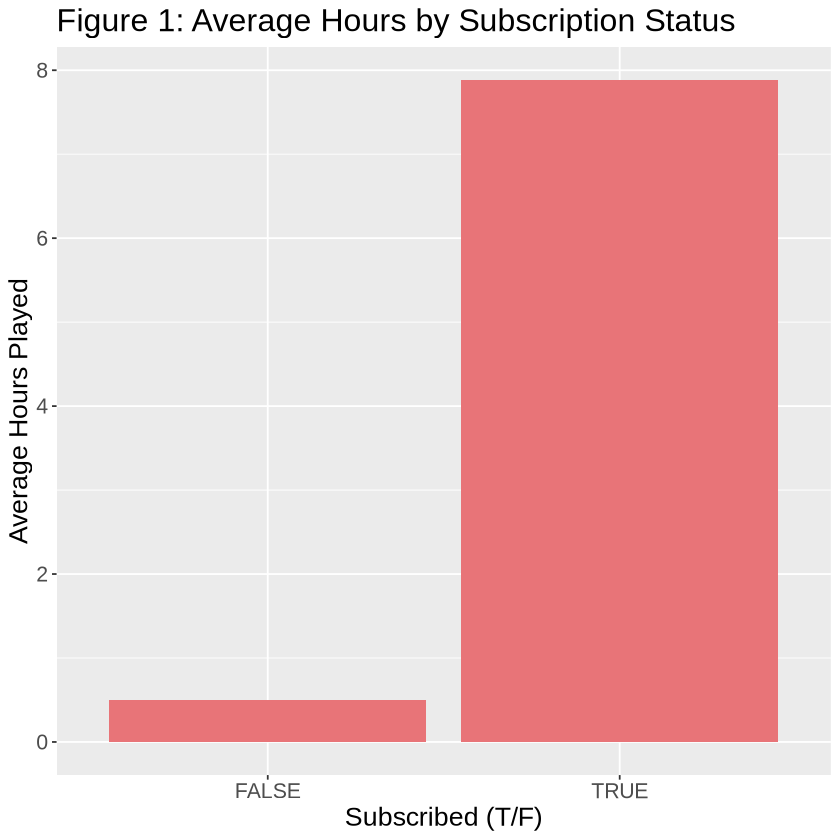

In [6]:
avg_hours_plot <- players_simplified |>
    group_by(subscribe) |>
    summarize(avg_hours = mean(played_hours)) |>
    ggplot(aes(x = subscribe, y = avg_hours)) +
        geom_bar(stat = "identity", fill = '#e87478') +  
        labs(title = 'Figure 1: Average Hours by Subscription Status', 
             x = 'Subscribed (T/F)', 
             y = 'Average Hours Played') +
        theme(text = element_text(size = 16))

avg_hours_plot

The bar graph first uses `group_by` and `summarize` to calculate the average hours played based on their subscription status. We then use `ggplot` to create the plot, classifying subscription status as x and average played hours as y. Next, we use `geom_bar`, classifying the `stat` argument as "identity" and adding a fill colour of #e87478 for visual clarity. We add labels for the title, x-axis, and y-axis using `labs`, and increase the text size to 16 with a theme for readability. We chose a bar graph to compare average `played_hours` across `subscribe` categories, aiming to identify if subscription status affects hours played during EDA. The results show subscribers averaging 7 hours and non-subscribers 2 hours, suggesting a pattern between `played_hours` and `subscribe`. The strong pattern between the two could suggest a high accuracy for our classification model. This class imbalance can be addressed by splitting using `strata = subscribe` to maintain proportions and focus on recall later on.

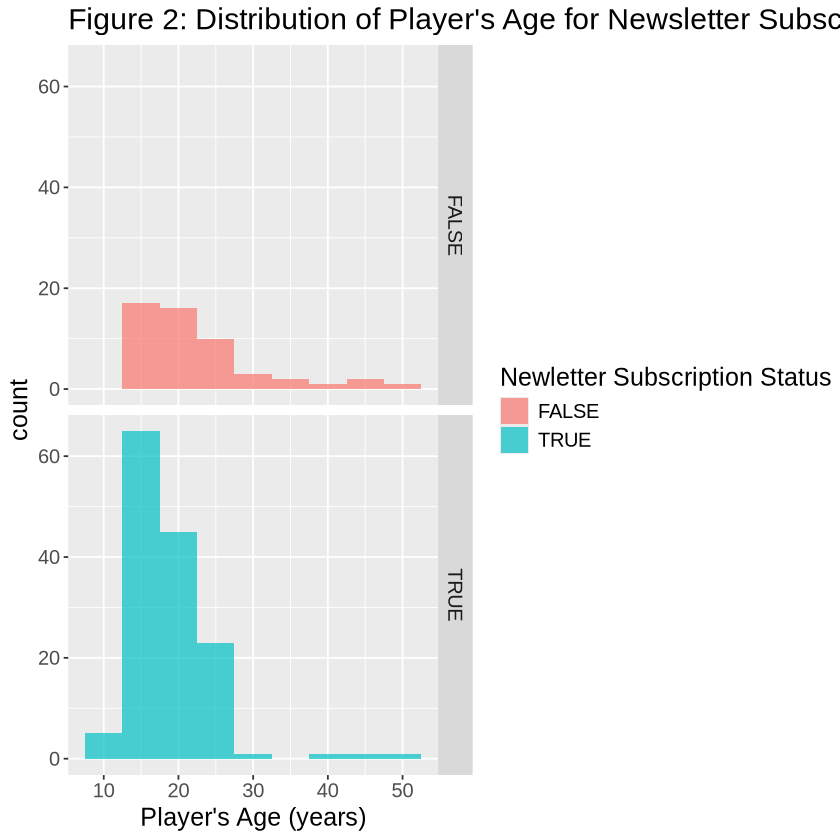

In [7]:
players_histogram <- players_simplified |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(binwidth = 5, position = "dodge", alpha = 0.7) +
    labs( x = "Player's Age (years)", fill = "Newletter Subscription Status",
         title = "Figure 2: Distribution of Player's Age for Newsletter Subscription") +
    facet_grid(rows = vars(subscribe)) +
    theme(text = element_text(size = 15))

players_histogram

We create a histogram to examine the distribution of `age` by `subscribe` status in the players_simplified dataset during EDA. Using `ggplot`, we plot `age` on the x-axis, facet by `subscribe`, and use `geom_histogram` with 30 bins, coloring FALSE in pink and TRUE in teal for clarity. We add labels for the title, x-axis, and y-axis using `labs`, and set text size to 16 for readability. 

We chose a faceted histogram to compare the `age` distribution across subscribe categories, aiming to explore if `age` varies by subscription status during EDA. The results show non-subscribers (FALSE) are mostly 15-25 with outliers up to 50, while subscribers (TRUE) are concentrated at 10-20, suggesting a pattern between `age` and `subscribe`. This could also suggest a high accuracy for our model. This shows how age varies, which helps $k$-NN classify based on distances, and highlights the need to address class imbalance in later steps for fair evaluation.

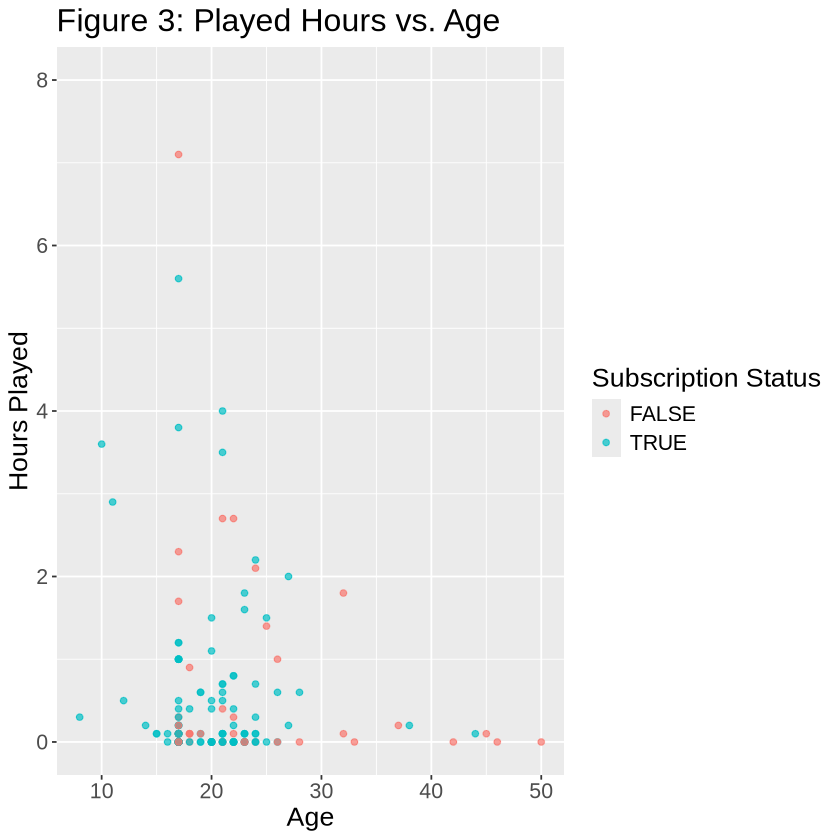

In [9]:
age_vs_hours_plot <- players_simplified |>
    ggplot(aes(x = age, y = played_hours, colour = subscribe)) +
        geom_point(alpha = 0.7) +
        labs(x = 'Age',
             y = 'Hours Played',
             colour = 'Subscription Status',
             title = 'Figure 3: Played Hours vs. Age') +
             theme(text = element_text(size = 16)) +
    coord_cartesian(ylim = c(0, 8))

age_vs_hours_plot

We create a scatterplot to explore `played_hours` vs. `age` in the `players_simplified` dataset during EDA. Using `ggplot`, we map `age` to the x-axis, `played_hours` to the y-axis, and color points by `subscribe` (FALSE is pink, TRUE is teal) with `geom_point`. We add labels using `labs` and set text size to 16 for readability. `alpha` = 0.7 was used to make the points easier to visualize and the y-axis was scaled to see the trend at the bottom of the graph.

We chose a scatterplot to examine the relationship between two continuous predictors, aiming to see if `age` and `played_hours` together form patterns related to `subscribe` during EDA. The results show no clear pattern between age and played_hours combined in relation to subscribe, despite individual patterns seen earlier. It could potentially mean our classifier based off the combined predictors may not be as high of an accuracy compared to individually. This suggests limited joint predictive power for $k$-NN’s distance-based classification, and underscores the need to handle class imbalance in later steps.

## Both Predictors

We have decided on using 3 predictor combinations.

We modeled our $k$-NN with both predictors (played_hours and age), `played_hours` alone, and `age` alone to classify subscribe to compare their predictive power. The bar graph showed that subscribers average 7 hours of playtime compared to the 2 hours of non-subscribers, a clear distinction that justifies played_hours as a standalone predictor. The histogram indicated that subscribers are younger (mostly 10-20 years old) while non-subscribers are older on average (15-25 years old), suggesting age is also informative. Since the scatterplot did not show a joint pattern, we tested both predictors together to explore a potential combined effect(s), while also modelling each predictor alone to test their individual contributions. This ensures a thorough evaluation of the effectiveness in $k$-NN’s classification.

In [8]:
set.seed(2000)
players_simplified <- players_simplified |>
    mutate(subscribe = as_factor(subscribe))

players_split <- initial_split(players_simplified, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

In [9]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

In [10]:
players_vfold <- vfold_cv(players_train, v = 3, strata = subscribe)

In [11]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

In [12]:
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

players_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy")

We set a seed of 2000 for reproducibility and convert `subscribe` to a factor in `players_simplified` for classification. We split the data into 75% training and 25% testing sets using `strata = subscribe` to maintain class proportions. A recipe normalizes and centers `age` and `played_hours` for $k$-NN’s distance calculations. We perform 3-fold cross-validation on the training set, choosing 3 folds instead of 5 due to insufficient cases in each class with 5 folds. We define a $k$-NN model, testing 1 to 20 neighbors as accuracy peaked around this range, and collect accuracy metrics to select the optimal $k$ for classifying `subscribe`.

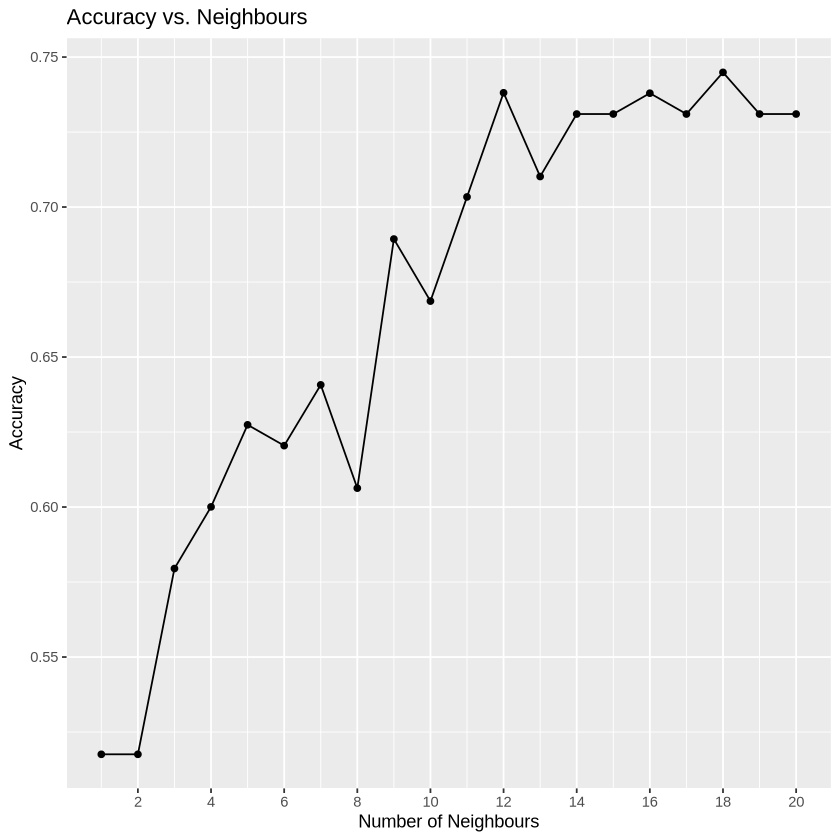

In [13]:
neighbours_plot <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of Neighbours", y = "Accuracy", title = "Accuracy vs. Neighbours") +
        scale_x_continuous(breaks = seq(0, 20, by = 2))
neighbours_plot

We plot accuracy against the number of neighbors, with the x-axis (0 to 20) and y-axis (0.5 to 0.75) showing accuracy increasing to around 0.75 at $k$ = 18, then stabilizing with slight fluctuations. This plot helps select the optimal $k$ for $k$-NN classification of `subscribe`, building on the earlier split using `strata = subscribe` for balanced evaluation.

In [14]:
knn_spec_predict <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_predict) |>
    fit(data = players_train)

In [15]:
players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)

players_predictions

players_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_metrics

.pred_class,age,subscribe,played_hours
<fct>,<dbl>,<fct>,<dbl>
TRUE,22,TRUE,0.0
TRUE,23,TRUE,1.6
TRUE,17,TRUE,0.0
⋮,⋮,⋮,⋮
TRUE,22,TRUE,32.0
TRUE,17,FALSE,1.7
TRUE,17,FALSE,0.0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


We define a $k$-NN model with $k$ = 18, selected from the accuracy plot, using a rectangular weight function for classification. The model is fitted on the training set and predicts subscribe on the test set, producing a table of 49 rows with predicted classes, age, subscribe, and played_hours. This applies $k$-NN’s distance-based classification to unseen data, using the earlier split for balanced representation. We calculate the test set accuracy, comparing predicted classes to true subscribe values, getting 0.755102.

## Hours Predictor

In [16]:
set.seed(2000)
players_recipe_hours <- recipe(subscribe ~ played_hours, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

In [17]:
players_results_hours <- workflow() |>
      add_recipe(players_recipe_hours) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy")

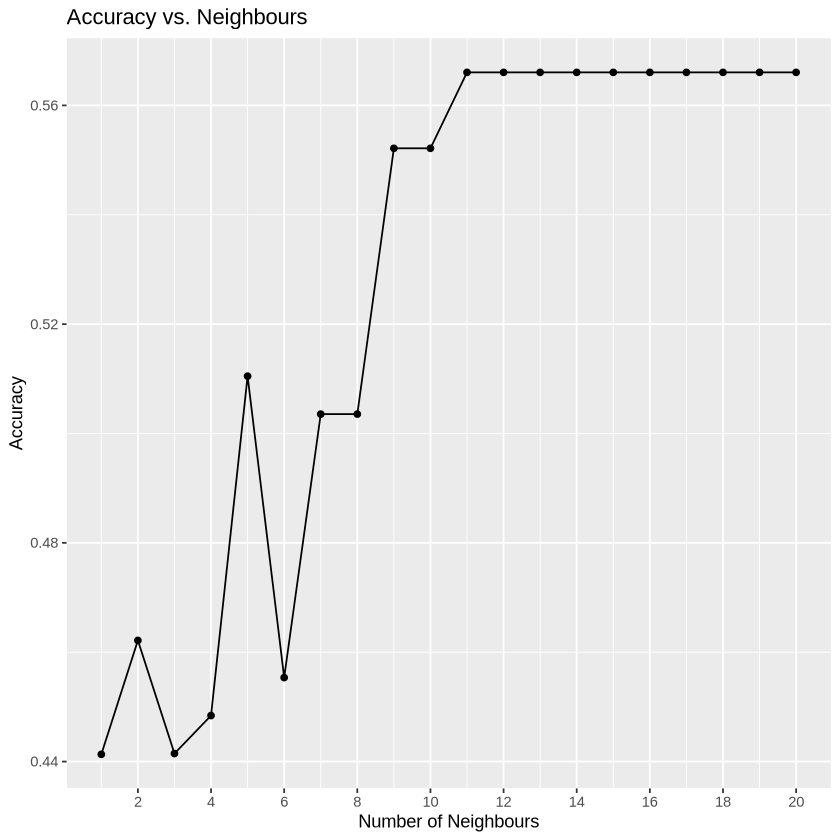

In [18]:
neighbours_plot_hours <- players_results_hours |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of Neighbours", y = "Accuracy", title = "Accuracy vs. Neighbours") +
        scale_x_continuous(breaks = seq(0, 20, by = 2))

neighbours_plot_hours

We create a recipe using only played_hours to classify `subscribe`, normalizing and centering the predictor. We tune the $k$-NN model by testing 1 to 20 neighbors with 3-fold cross-validation, collecting accuracy metrics. The plot shows accuracy on the y-axis (0.45 to 0.65) against neighbors on the x-axis (0 to 20), increasing from 0.44 to 0.46, dipping back down to 0.44 at $k$ = 3, then rising to ~0.58 at $k$ = 11 and stabilizing. This helps select the optimal $k$ for $k$-NN, using the earlier split with `strata = subscribe`.

In [21]:
knn_spec_predict_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit_hours <- workflow() |>
    add_recipe(players_recipe_hours) |>
    add_model(knn_spec_predict_hours) |>
    fit(data = players_train)

In [22]:
players_predictions_hours <- predict(players_fit_hours, players_test) |>
    bind_cols(players_test)

players_metrics_hours <- players_predictions_hours |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_metrics_hours

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5918367


We define a $k$-NN model with $k$ = 11, selected from the accuracy plot, using a rectangular weight function to classify `subscribe` with `played_hours`. The model is fitted on the training set using the preprocessing recipe and predicts `subscribe` on the test set, producing a table of predicted classes, `played_hours`, and `subscribe`. We calculate the test set accuracy, comparing predicted classes to true values, achieving 0.5918367.

## Age Predictor

In [23]:
set.seed(2000)
players_recipe_age <- recipe(subscribe ~ age, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

In [24]:
players_results_age <- workflow() |>
      add_recipe(players_recipe_age) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy")

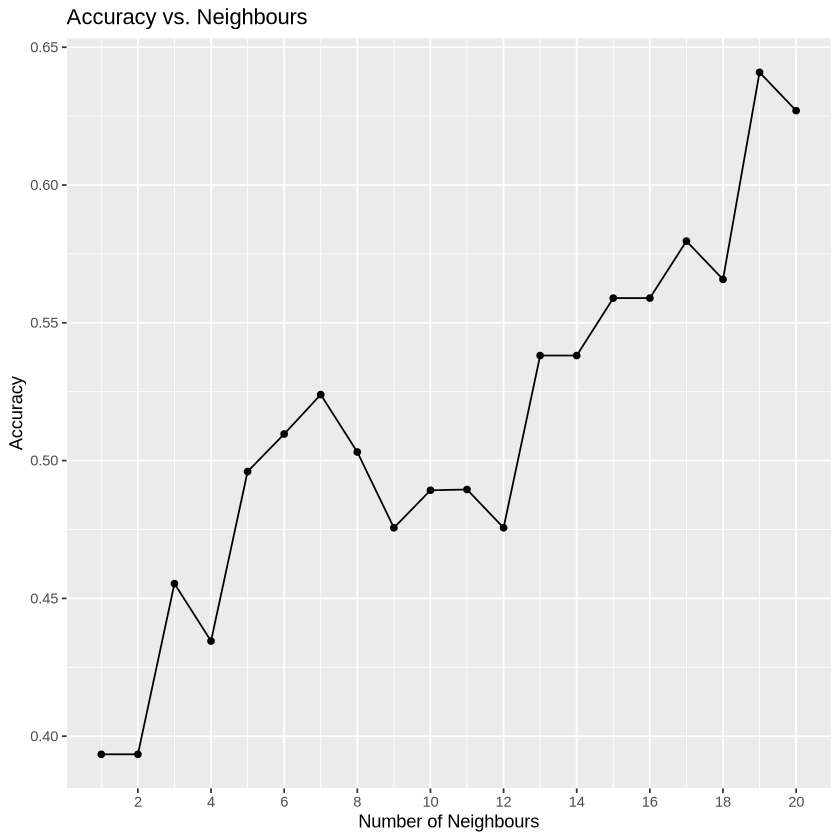

In [25]:
neighbours_plot_age <- players_results_age |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of Neighbours", y = "Accuracy", title = "Accuracy vs. Neighbours") +
        scale_x_continuous(breaks = seq(0, 20, by = 2))

neighbours_plot_age

For the age predictor, we create a recipe using only `age` to classify `subscribe`, normalizing and centering the predictor. We tune the $k$-NN model by testing 1 to 20 neighbors with 3-fold cross-validation, collecting accuracy metrics. The plot shows accuracy on the y-axis (0.4 to 0.65) against neighbours on the x-axis (0 to 20), increasing from 0.38 to 0.45, dipping to 0.43 at $k$ = 4, then rising to ~0.65 at $k$ = 19 and stabilizing. This helps select the optimal $k$ for $k$-NN, using the earlier split with `strata = subscribe`.


In [26]:
knn_spec_predict_age <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit_age <- workflow() |>
    add_recipe(players_recipe_age) |>
    add_model(knn_spec_predict_age) |>
    fit(data = players_train)

In [27]:
players_predictions_age <- predict(players_fit_age, players_test) |>
    bind_cols(players_test)

players_metrics_age <- players_predictions_age |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_metrics_age

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5306122


We define a $k$-NN model with $k$ = 19, selected from the accuracy plot, using a rectangular weight function to classify `subscribe` with `age`. The model is trained on the training set with the preprocessed recipe and predicts `subscribe` on the test set, producing a table of predicted classes, `age`, and `subscribe`. We calculate the test set accuracy, comparing predicted classes to true values, getting a value of 0.5306122.

# Discussion

Through the classification model, we found that using both predictors (`played_hours` and `age`) yielded the highest accuracy, around 75.51%. The individual `played_hours` and `age` predictors achieved an accuracy of around 59.18% and 53.06%, respectively.  The low accuracy of the `age` predictor suggests it was not able to learn a relationship and performed poorly, randomly guessing. In contrast when combining the two predictors, the $k$-NN model was able to learn the trends/patterns for an improved performance. 

We anticipated that `played_hours` and `age` would individually contribute to predicting the newsletter subscription status. However, the results showed that neither were a reliable predictor due to its low accuracy, which was unexpected. Combining the two variables yields the highest accuracy. That was also unexpected as there did not seem to have a clear pattern when observing the visualizations, especially the scatterplot with both predictors.

These findings can impact marketing strategies to improve newsletter subscriptions, player engagement and retention. By understanding that the relationship between players’ age and hours played can predict their newsletter subscription, there can be targeted marketing as a result. Flyers and campaigns can be customized to appeal to and attract certain age groups with specific gaming behaviours. Thus, increasing the overall player engagement and subscription numbers.

A future question that this research could lead to can be: what other variables can be involved to predict the newsletter subscription status of players, such as in-game purchases? It can also lead to inferential questions such as why do age and amount of hours played influence the newsletter subscription status? Could it be due to psychological or environmental reasons? 